In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.fft import rfftn,fftfreq,rfftfreq

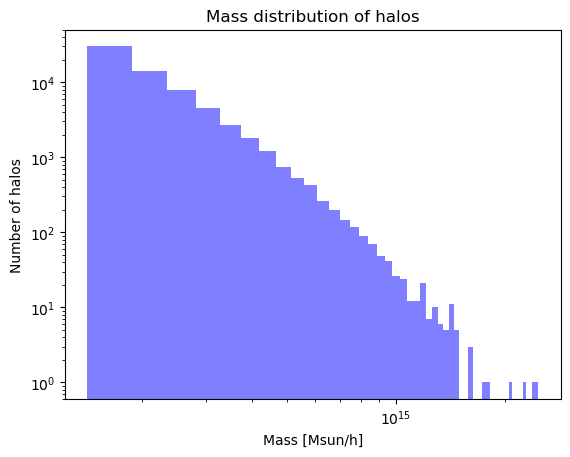

Cell size:  42.0
Mean density in the cell:  0.24880599975585938


In [2]:
L=2688
volume=L**3

#create particles
x,y,z=np.genfromtxt('cluster2.txt',usecols=(1,2,3),unpack=True)/1000  #sono in kpc/h!!!, faccio/1000
mass = np.genfromtxt('cluster2.txt',usecols=(7),unpack=True) #masse degli aloni in Msun/h
n_points=len(x)
density=n_points/volume

plt.hist(mass, bins = 50, color = 'blue', alpha = 0.5)
plt.xlabel('Mass [Msun/h]')
plt.ylabel('Number of halos')
plt.title('Mass distribution of halos')
plt.xscale('log')
plt.yscale('log')
plt.show()

# %%
n_cells=64 #è un nostro parametro, def fino  ache scala voglio misuare Pk, meglio se è multiplo di 2 per dopo
cell_size=L/n_cells
print("Cell size: ",cell_size) #mpc/h

#compute the mean density
cell_mean_density=n_points/n_cells**3
print("Mean density in the cell: ",cell_mean_density) #mpc**-3/h**3

Cell size:  42.0
Mean density in the cell:  0.24880599975585938


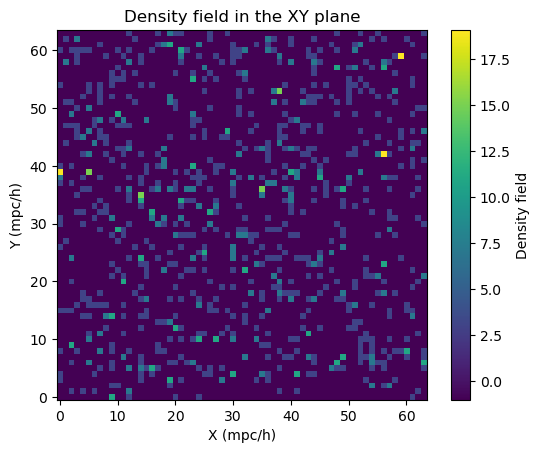

In [3]:
n_cells=64 #è un nostro parametro, def fino  ache scala voglio misuare Pk, meglio se è multiplo di 2 per dopo
cell_size=L/n_cells
	
n_cells=64 #è un nostro parametro, def fino  ache scala voglio misuare Pk, meglio se è multiplo di 2 per dopo
cell_size=L/n_cells
print("Cell size: ",cell_size) #mpc/h

#compute the mean density
cell_mean_density=n_points/n_cells**3
print("Mean density in the cell: ",cell_mean_density) #mpc**-3/h**3

#create density grid with histogramdd
grid,edges=np.histogramdd((x,y,z),bins=(n_cells,n_cells,n_cells),range=((0,L),(0,L),(0,L)))

#compute the density field
density_field=(grid-cell_mean_density)/cell_mean_density 

plt.imshow(density_field[:,:,0],origin='lower',cmap='viridis')
plt.colorbar(label='Density field')
plt.title('Density field in the XY plane')
plt.xlabel('X (mpc/h)')
plt.ylabel('Y (mpc/h)')
plt.show()

/home/elena/anaconda3/envs/acc-env/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/elena/anaconda3/envs/acc-env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


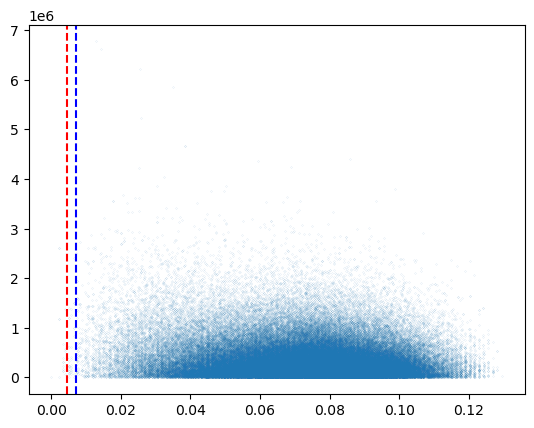

In [4]:
	
#compute the delta in fourier space
delta_k=rfftn(density_field)/n_cells**3  #normmalizzo per il number di celle  
#è oggetto grande: (64,64,33) e vale che f(-k)=f*(k) e f(k)=f(-k) (coniugato)

#create the k grid
kF=2*np.pi/L  #fondamental frequency in mpc**-1/h
H=L/n_cells
kN=np.pi/H   #Nyquist frequency in mpc**-1/h
kx=fftfreq(n_cells,d=1/n_cells)*kF
ky=fftfreq(n_cells,d=1/n_cells)*kF
kz=rfftfreq(n_cells,d=1/n_cells)*kF

KX,KY,KZ=np.meshgrid(kx,ky,kz)
KK=np.sqrt(KX**2+KY**2+KZ**2)  

#calcolo spettro di pot su griglia
pk_grid=delta_k*np.conjugate(delta_k)*volume  #metto il volume perchè non sono nel continuo ma nel discreto
#ora devo fare binning griglia per avere p(|k|)
#Binning
c=1
k_edges=np.arange(kF,kN,c*kF) 
k_bins=0.5*(k_edges[1:]+k_edges[:-1])
#print("k edges: ",k_edges)

plt.plot(KK.flatten(),pk_grid.flatten(),'.',markersize=0.1)
plt.axvline(k_edges[1], color='red', linestyle='--', label='kF')
plt.axvline(k_edges[2], color='blue', linestyle='--', label='kN')

In [5]:
pk_averaged=np.zeros(k_bins.shape)
k_averaged=np.zeros(k_bins.shape)

for i in range(len(k_bins)):
    mask=(KK.flatten()>=k_edges[i]) & (KK.flatten()<k_edges[i+1])
    pk_averaged[i]=np.mean(pk_grid.flatten()[mask])
    k_averaged[i]=np.mean(KK.flatten()[mask])

/tmp/ipykernel_82788/2786515712.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  pk_averaged[i]=np.mean(pk_grid.flatten()[mask])


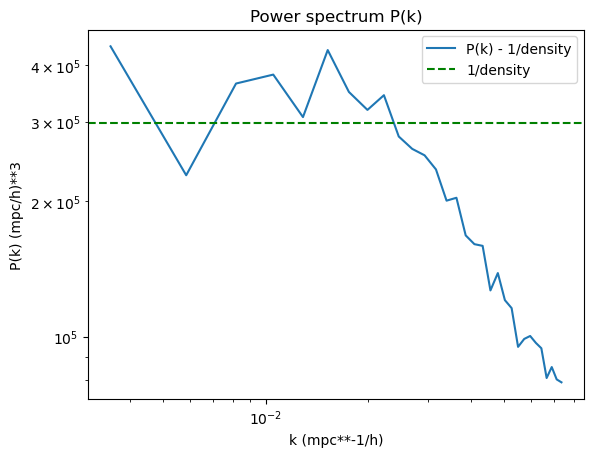

In [6]:
plt.loglog(k_bins,pk_averaged-1./density,label='P(k) - 1/density')
plt.axhline(1./density, color='green', linestyle='--', label='1/density')
plt.xlabel('k (mpc**-1/h)')
plt.ylabel('P(k) (mpc/h)**3')
plt.title('Power spectrum P(k)')
plt.legend()
plt.show()

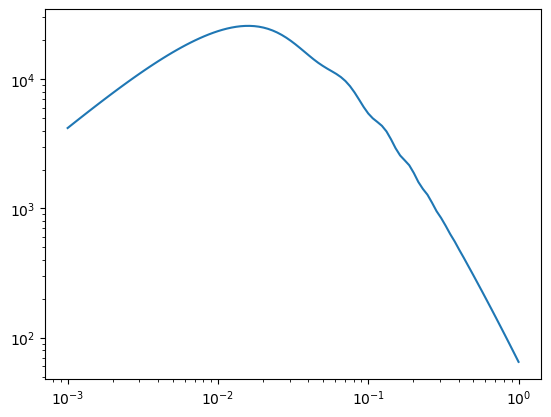

In [7]:
import camb
camb_params=camb.CAMBparams()
h=0.704
ombh2=0.022
omega_m=0.272
omch2=omega_m* h**2 -ombh2
camb_params.set_cosmology(H0=70.4,ombh2=0.022,omch2=0.12,mnu=0,num_massive_neutrinos=0)
camb_params.InitPower.set_params(ns=0.963)
camb_params.set_matter_power(redshifts=[0.,],kmax=2.0)

camb_results=camb.get_results(camb_params)
k,z,pk=camb_results.get_matter_power_spectrum(minkh=0.001,maxkh=1.0)

sigma8_z0=camb_results.get_sigma8_0()
pk_renorm=pk[0]*(0.809)**2/sigma8_z0**2
plt.loglog(k,pk_renorm)

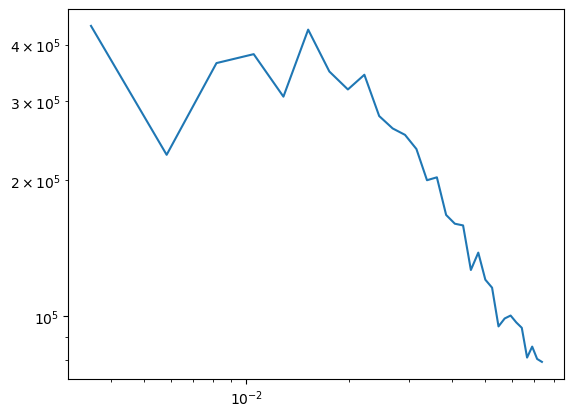

In [8]:
plt.loglog(k_bins,pk_averaged-1./density)
plt.show()

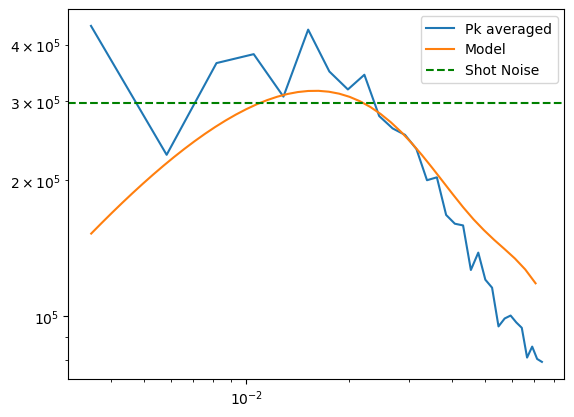

In [9]:
plt.loglog(k_bins,pk_averaged-1./density, label='Pk averaged')  #blue
b=3.5
plt.loglog(k[(k>k_bins[0]) &(k<k_bins[-1])],b**2*pk_renorm[(k>k_bins[0])&(k<k_bins[-1])], label='Model')  #arancione
plt.axhline(1./density,linestyle='--',label='Shot Noise',color='green')  #verde


plt.legend()
plt.show()